/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


9797
(10, 100, 28, 28, 1)
Iteration number  0
Iteration number  1
Iteration number  2
Iteration number  3
Iteration number  4
Iteration number  5
Iteration number  6
Iteration number  7
Iteration number  8
Iteration number  9
Iteration number  10
Iteration number  11
Iteration number  12
Iteration number  13
Iteration number  14
Iteration number  15
Iteration number  16
Iteration number  17
Iteration number  18
Iteration number  19


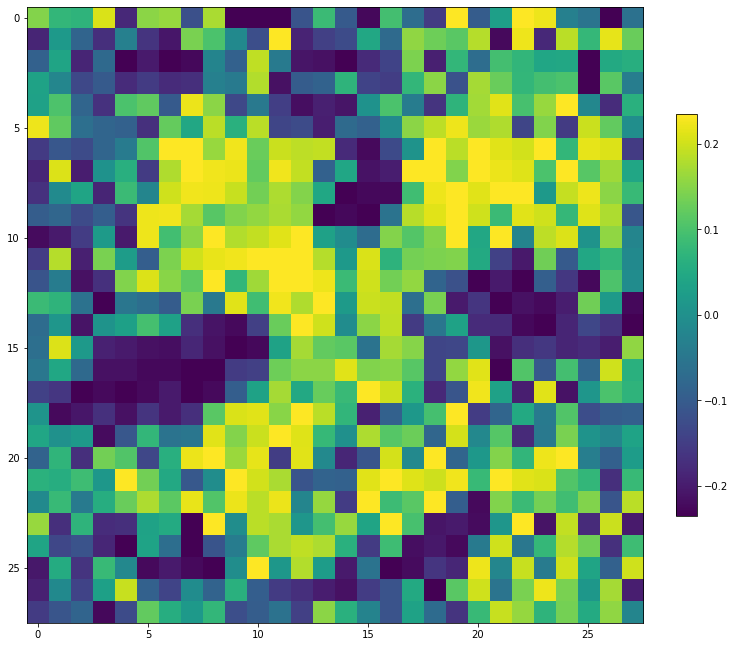

In [1]:
from algorithms import *
from lenet5 import *
import numpy as np
import matplotlib.pyplot as plt

_, (test_x, test_y) = load_MNIST()

path = './data/lenet5'

lenet5 = LeNet5(path=path, load=True)

epsilon = 0.25
d = 28*28

lab = lenet5.predict(test_x)
indexes = lab == test_y
data = test_x[indexes]
labels = test_y[indexes]

print(len(labels))  # 9826

# M = num workers; we consider a number of workers <=10
M = 10
data_per_classes = []
for label_class in range(0, 10):
    data_per_classes.append(data[labels == label_class][:100])

data_per_classes = np.array(data_per_classes)
data_workers = []

for offset in range(0, 100, M):
    image_worker = []
    for c in range(0, 10):
        image_worker.extend(data_per_classes[c, offset:offset+M, :, :, :])
    data_workers.append(image_worker)

data_workers = np.array(data_workers)
print(data_workers.shape)  # now all 10 workers have 100 images, 10 for each class.

y = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.repeat(y, 10)

m = 10
T = 20
delta = decentralized_stochastic_gradient_free_FW(data_workers, y, lenet5.negative_loss, m, T, M, epsilon, d)

fig, ax = plt.subplots(figsize=(12, 12))
img = plt.imshow(delta[-1].reshape((28, 28)))
fig.colorbar(img, ax=ax, fraction=0.03, pad=0.05)
plt.savefig(f"./perturbation_{m}", bbox_inches="tight")
plt.show()

In [11]:
np.save(f"./data/perturbation_{m}", delta[-1])
loaded_delta = np.load(f"./data/perturbation_{m}.npy")
loaded_delta.shape

(784,)

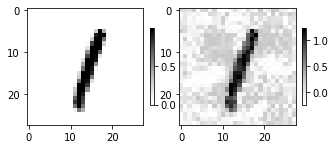

[8]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [12]:
image = test_x[5].numpy().reshape(28,28)
img_noise = image + delta[-1].reshape((28, 28))
fig, ax = plt.subplots(1, 2,figsize=(5, 5))
a = ax[0].imshow(image, cmap='Greys')
b = ax[1].imshow(img_noise, cmap='Greys')
fig.colorbar(a, ax=ax[0], fraction=0.03, pad=0.05)
fig.colorbar(b, ax=ax[1], fraction=0.03, pad=0.05)

plt.savefig(f"./image_perturbation_example_{m}", bbox_inches="tight")
plt.show()
print(lenet5.predict(np.array([img_noise.reshape(28, 28 ,1)])))

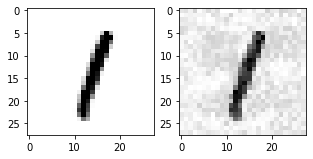

[8]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [13]:
image = test_x[5].numpy().reshape(28,28)
delta_mean = np.mean(delta, axis=0)
img_noise = image + delta_mean.reshape((28, 28))
fig, ax = plt.subplots(1, 2,figsize=(5, 5))
ax[0].imshow(image, cmap='Greys')
ax[1].imshow(img_noise, cmap='Greys')
plt.savefig(f"./image_perturbation_example_{m}", bbox_inches="tight")
plt.show()
print(lenet5.predict(np.array([img_noise.reshape(28, 28 ,1)])))

In [22]:
perturbation = np.tile(delta[-1], data.shape[0])
perturbation = perturbation.reshape((data.shape[0],28,28,1))
perturbated_data = data + perturbation
perturbated_data = np.clip(perturbated_data, 0., 1.)

In [23]:
lenet5.model.evaluate(perturbated_data, labels)

307/307 [==============================] - 3s 10ms/step - loss: 2.3129 - accuracy: 0.6238


[2.312938928604126, 0.6237623691558838]

In [16]:
lenet5.model.evaluate(data, labels)

307/307 [==============================] - 3s 10ms/step - loss: 0.0113 - accuracy: 1.0000


[0.011310586705803871, 1.0]

In [30]:
gaussian_noise_data = data + np.random.normal(0, 0.3, data.shape)
gaussian_noise_data = np.clip(gaussian_noise_data, 0., 1.)
lenet5.model.evaluate(gaussian_noise_data, labels)

307/307 [==============================] - 3s 10ms/step - loss: 1.0043 - accuracy: 0.8067


[1.004286766052246, 0.8066754937171936]

In [25]:
gaussian_noise_data.shape

(9797, 28, 28, 1)

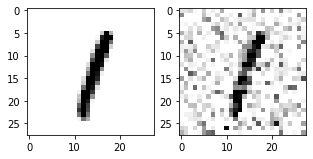

In [31]:
gaussian_noise = np.random.normal(0, 0.3, (28,28))
fig, ax = plt.subplots(1, 2,figsize=(5, 5))
ax[0].imshow(image, cmap='Greys')
ax[1].imshow(np.clip(image+gaussian_noise, 0.,1.), cmap='Greys')
plt.savefig(f"./gaussian_noise_{m}", bbox_inches="tight")
plt.show()
